# Тестирование гипотезы на синтетических данных, обладаемых нужными свойствами.

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import tangent_space_cov, optimal_cpd_rank, get_tssa_train_fc, tssa_cov_split
from tSSA import t_SSA
from journal_style import EnableJournalStylePlotting
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.distance import distance_riemann

In [2]:
random_state = 42

In [3]:
np.random.seed(42)
ts_size = 6000
x = np.linspace(0, 1000, ts_size)
noise = np.random.standard_normal(size=ts_size)

### Создадим синтетический, нескоррелированный набор из 2 рядов

In [51]:
z1 = 10 + np.sin(0.2 * x) + noise
z2 = 12 + 2 * np.sin(0.21 * x) + np.random.standard_normal(size=6000)

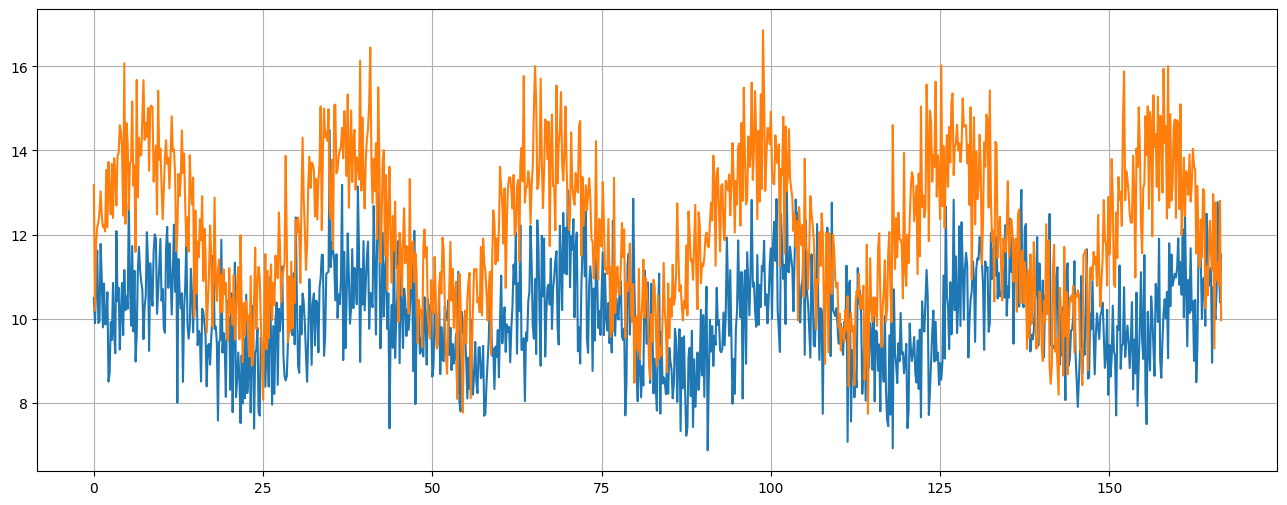

In [52]:
figure, ax = plt.subplots(figsize=(16, 6))

ax.plot(x[:1000], z1[:1000])
ax.plot(x[:1000], z2[:1000])
ax.grid()
plt.show()

<Axes: >

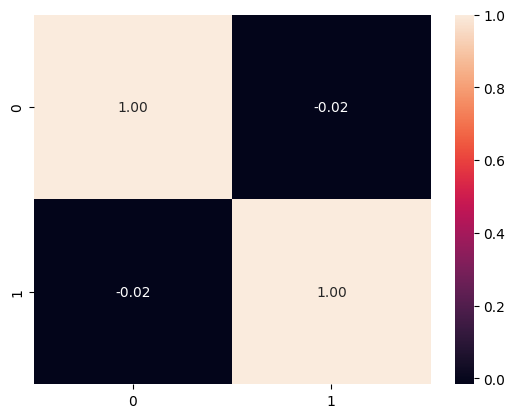

In [53]:
ts_df_uncorr = pd.DataFrame([z1, z2]).T
sns.heatmap(ts_df_uncorr.corr(),annot=True, fmt='.2f')

### Исследование нескоррелированного прогноза

In [7]:
train_ts_uncorr = ts_df_uncorr.iloc[:ts_size - 250, :]
test_ts_uncorr = ts_df_uncorr.iloc[ts_size - 250:, :]
w_size = 600
k = 1

In [8]:
cov = Covariances(estimator='corr')
X = np.array([train_ts_uncorr.to_numpy().T[:, i * k:i * k + w_size] for i in range(((train_ts_uncorr.shape[0] - w_size + 1) // k + 1) - 1)])
est_cov = cov.transform(X)

In [9]:
print(est_cov[506])

[[ 1.         -0.07568549]
 [-0.07568549  1.        ]]


In [ ]:
print(distance)

In [10]:
tsp_z = tangent_space_cov(train_ts_uncorr, w_size)

#### Визуализация вложений в касательное пространство

In [11]:
pca = PCA()
pca.fit(tsp_z)

PCA()

In [12]:
explained_var = np.cumsum(pca.explained_variance_ratio_)

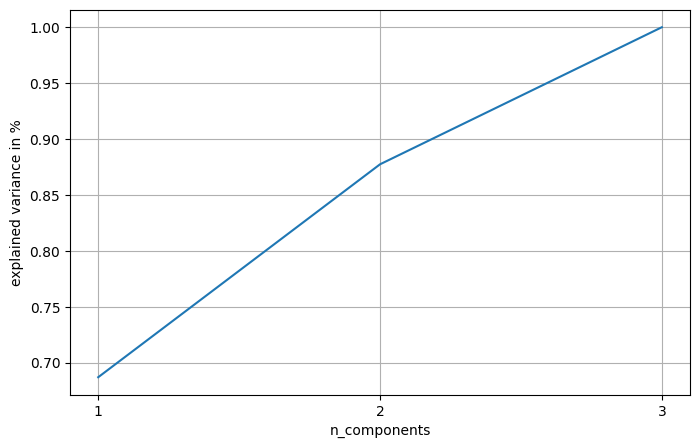

In [13]:
figure, ax = plt.subplots(figsize=(8, 5))

ax.plot([i for i in range(1, pca.n_components_ + 1)], explained_var)
ax.grid()
ax.set_xticks([i for i in range(1, pca.n_components_ + 1)])
ax.set_xlabel("n_components")
ax.set_ylabel("explained variance in %")
plt.show()

In [14]:
tsp_z_pca = PCA(n_components=3).fit_transform(tsp_z)

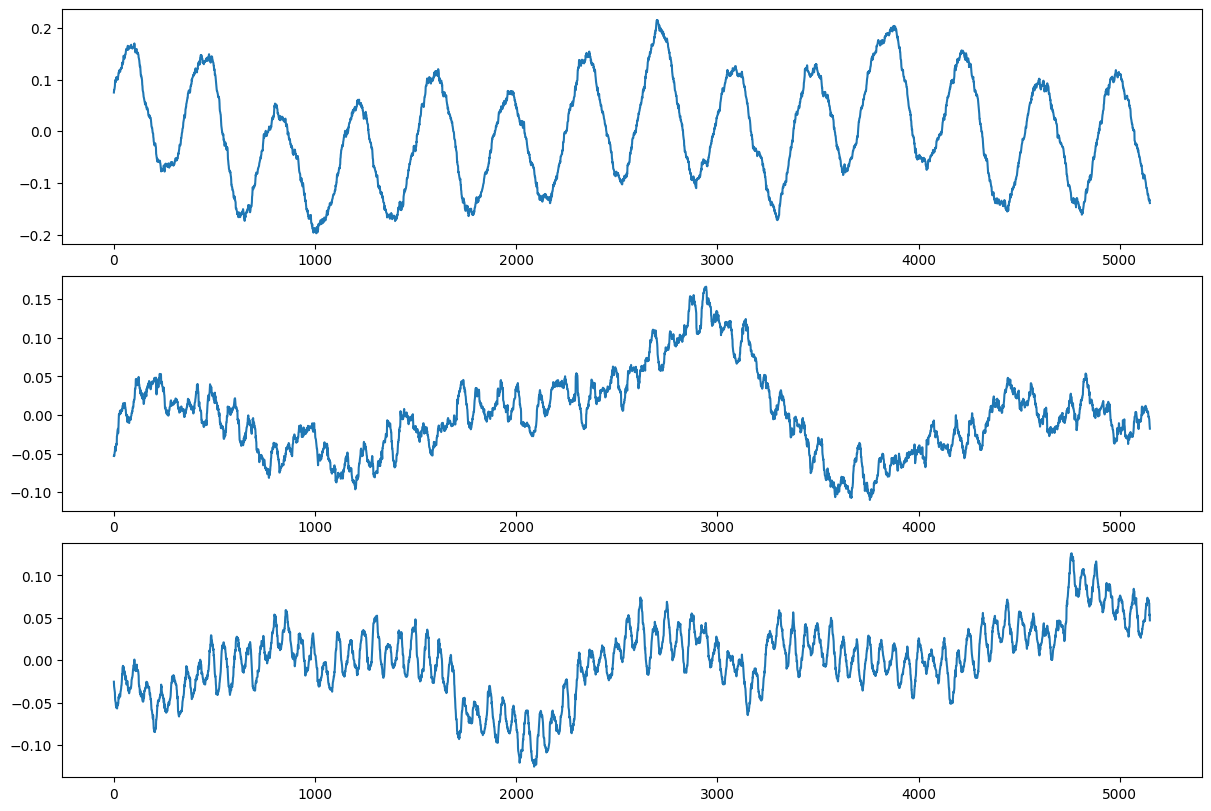

In [15]:
figure, ax = plt.subplots(3, 1, figsize=(12, 8), layout='constrained')
ax[0].plot(tsp_z_pca[:, 0], label=r'1st component')
ax[1].plot(tsp_z_pca[:, 1], label=r'2nd component')
ax[2].plot(tsp_z_pca[:, 2], label=r'3rd component')



plt.show()

#### Возвращаемся к прогнозу

In [16]:
train_ts_uncorr = train_ts_uncorr.to_numpy()
test_ts_uncorr = test_ts_uncorr.to_numpy()

In [174]:
cpd_rank_result = optimal_cpd_rank(train_ts_uncorr[:train_ts_uncorr.shape[0] - 250, :],
                                   train_ts_uncorr[train_ts_uncorr.shape[0] - 250:, :], w_size)

CP rank = 5


KeyboardInterrupt: 

In [17]:
optimal_rank = 5
t_ssa = t_SSA(w_size, train_ts_uncorr.T, optimal_rank)
t_ssa.decompose_tt(random_state=random_state)

In [18]:
pred_ts_uncorr, actual_train_ts_uncorr = get_tssa_train_fc(t_ssa, train_ts_uncorr, w_size)

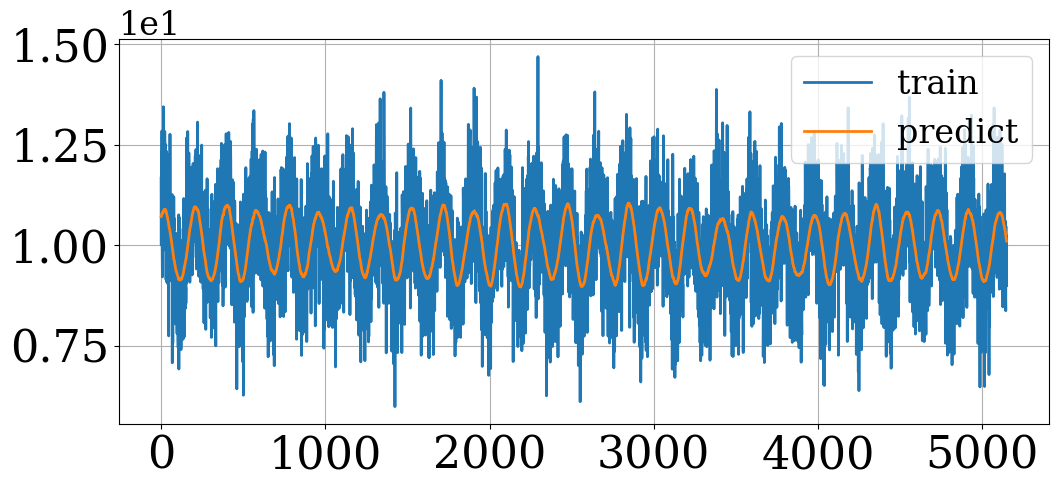

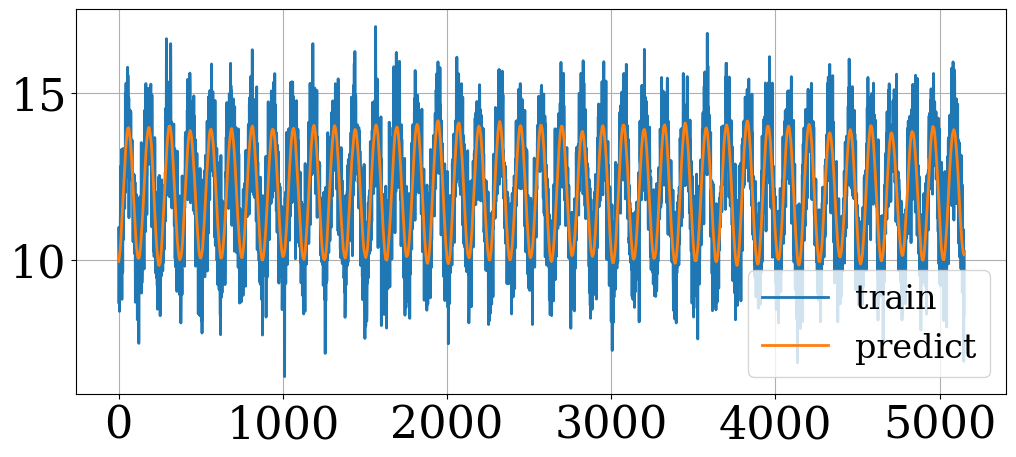

In [19]:
for i in range(actual_train_ts_uncorr.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(actual_train_ts_uncorr.T[i], label='train')
        ax.plot(pred_ts_uncorr.T[i], label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

In [20]:
# get MSE for every signal
signals_mse_tssa = np.mean((pred_ts_uncorr - actual_train_ts_uncorr) ** 2, axis=0)
# get MAPE for every signal
signals_mape_tssa = np.mean(np.abs((pred_ts_uncorr - actual_train_ts_uncorr) / actual_train_ts_uncorr), axis=0)

mean_mse = np.mean(signals_mse_tssa)
mean_mape = np.mean(signals_mape_tssa)

print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa):e}')

MSE: [1.03837644 1.01547579]; Mean by signals = 1.026926e+00
MAPE: [0.08343624 0.06896402]; Mean by signals = 7.620013e-02


### Добавление ковариации к прогнозу tSSA

In [21]:
X_train, X_test, y_train,  y_test = tssa_cov_split(pred_ts_uncorr, actual_train_ts_uncorr, tsp_z)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [24]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_transformed, y_train)

LinearRegression()

In [25]:
y_pred_train = linear_reg.predict(X_train_transformed)
y_pred_test = linear_reg.predict(X_test_transformed)

In [26]:
# get MSE for every signal
train_mse_cov_tssa = np.mean((y_pred_train - y_train) ** 2, axis=0)
# get MAPE for every signal
train_mape_cov_tssa = np.mean(np.abs((y_pred_train - y_train) / y_train), axis=0)

print(f'train_MSE: {train_mse_cov_tssa}; Mean by signals = {np.mean(train_mse_cov_tssa):e}')
print(f'train_MAPE: {train_mape_cov_tssa}; Mean by signals = {np.mean(train_mape_cov_tssa):e}')

train_MSE: [1.03959427 1.01781005]; Mean by signals = 1.028702e+00
train_MAPE: [0.08372588 0.06912389]; Mean by signals = 7.642488e-02


In [27]:
# get MSE for every signal
test_mse_cov_tssa = np.mean((y_pred_test - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape_cov_tssa = np.mean(np.abs((y_pred_test - y_test) / y_test), axis=0)

print(f'test_MSE: {test_mse_cov_tssa}; Mean by signals = {np.mean(test_mse_cov_tssa):e}')
print(f'test_MAPE: {test_mape_cov_tssa}; Mean by signals = {np.mean(test_mape_cov_tssa):e}')

test_MSE: [1.01975732 1.00378323]; Mean by signals = 1.011770e+00
test_MAPE: [0.08091771 0.06826526]; Mean by signals = 7.459148e-02


In [28]:
# get MSE for every signal
test_mse_tssa = np.mean((pred_ts_uncorr[y_train.shape[0]:] - y_test) ** 2, axis=0)
# get MAPE for every signal
test_mape_tssa = np.mean(np.abs((pred_ts_uncorr[y_train.shape[0]:] - y_test) / y_test), axis=0)

print(f'tssa_test_MSE: {test_mse_tssa}; Mean by signals = {np.mean(test_mse_tssa):e}')
print(f'tssa_test_MAPE: {test_mape_tssa}; Mean by signals = {np.mean(test_mape_tssa):e}')

tssa_test_MSE: [1.02126796 1.00393553]; Mean by signals = 1.012602e+00
tssa_test_MAPE: [0.08151853 0.06833372]; Mean by signals = 7.492613e-02


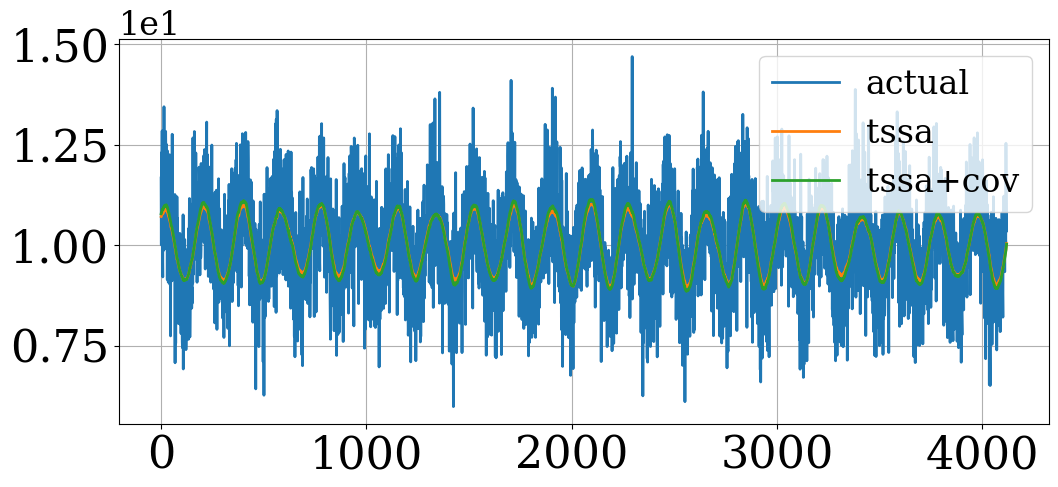

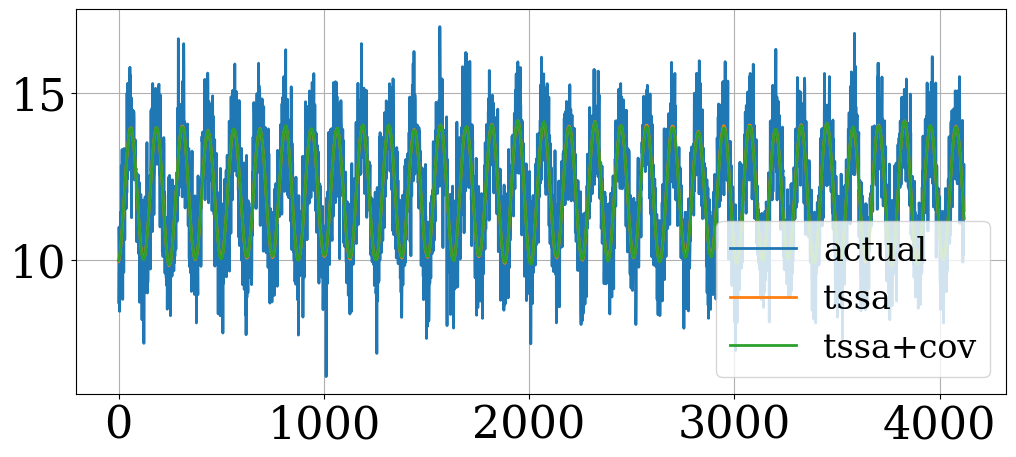

In [29]:
for i in range(actual_train_ts_uncorr.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(y_train.T[i], label='actual')
        ax.plot(pred_ts_uncorr.T[i, :y_train.shape[0]], label='tssa')
        ax.plot(y_pred_train.T[i], label='tssa+cov')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

### Создадим синтетический, скоррелированный набор из 2 временных рядов

In [111]:
y1 = 10 + np.sin(0.3 * x) + noise
y2 = 12 + 2 * np.sin(0.3048 * x) + noise

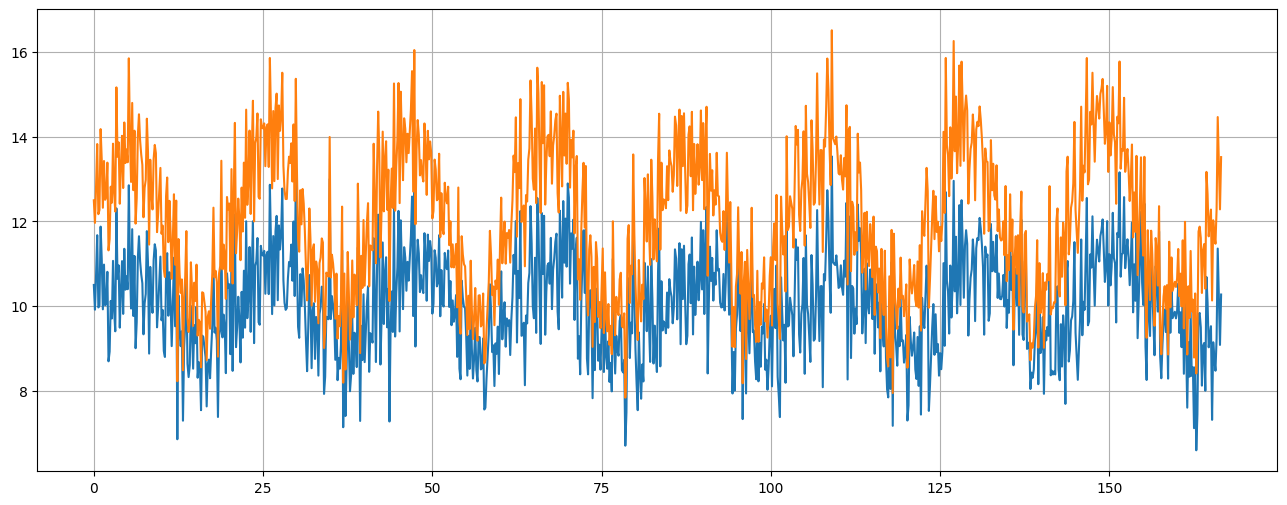

In [112]:
figure, ax = plt.subplots(figsize=(16, 6))

ax.plot(x[:1000], y1[:1000])
ax.plot(x[:1000], y2[:1000])
ax.grid()
plt.show()

<Axes: >

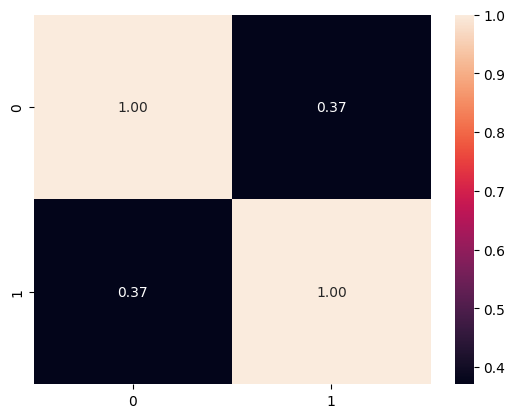

In [113]:
ts_df_corr = pd.DataFrame([y1, y2]).T
sns.heatmap(ts_df_corr.corr(),annot=True, fmt='.2f')

### Исследование скоррелированного прогноза

In [114]:
k = 1

In [115]:
train_ts_corr = ts_df_corr.iloc[:ts_size - 250, :]
test_ts_corr = ts_df_corr.iloc[ts_size - 250:, :]
w_size = 600

In [118]:
cov = Covariances(estimator='scm')
X = np.array([train_ts_corr.to_numpy().T[:, i * k:i * k + w_size] for i in range(((train_ts_corr.shape[0] - w_size + 1) // k + 1) - 1)])
est_cov = cov.transform(X)

In [119]:
print(est_cov[638])

[[1.53099592 1.87169351]
 [1.87169351 3.24513304]]


In [120]:
tsp_y = tangent_space_cov(train_ts_corr, w_size, est='scm')

#### Визуализируем ковариацию в касательном пространстве

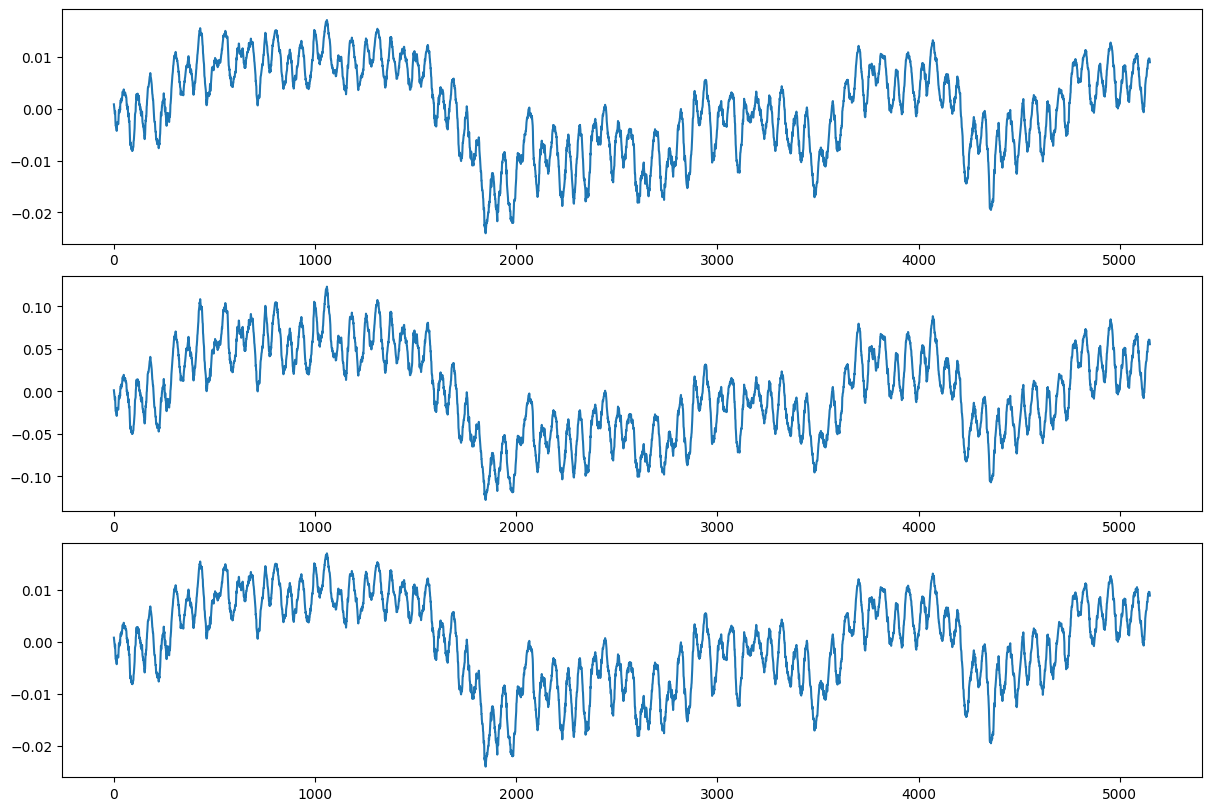

In [107]:
figure, ax = plt.subplots(3, 1, figsize=(12, 8), layout='constrained')
ax[0].plot(tsp_y[:, 0], label=r'1st component')
ax[1].plot(tsp_y[:, 1], label=r'2nd component')
ax[2].plot(tsp_y[:, 2], label=r'3rd component')



plt.show()

#### Вернемся к прогнозу

In [82]:
train_ts_corr = train_ts_corr.to_numpy()
test_ts_corr = test_ts_corr.to_numpy()

In [83]:
optimal_rank_corr = 5
t_ssa = t_SSA(w_size, train_ts_corr.T, optimal_rank_corr)
t_ssa.decompose_tt(random_state=random_state)

In [86]:
pred_ts_corr, actual_train_ts_corr = get_tssa_train_fc(t_ssa, train_ts_corr, w_size)

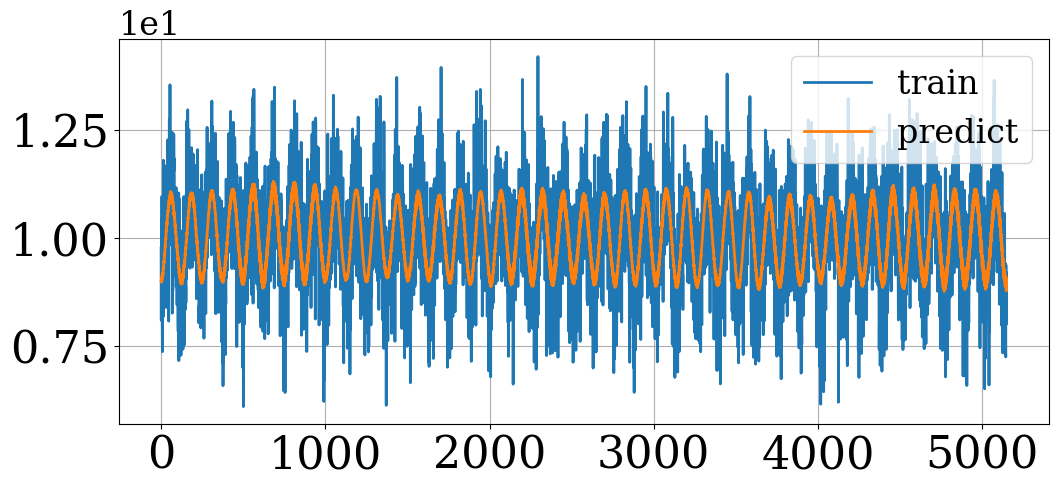

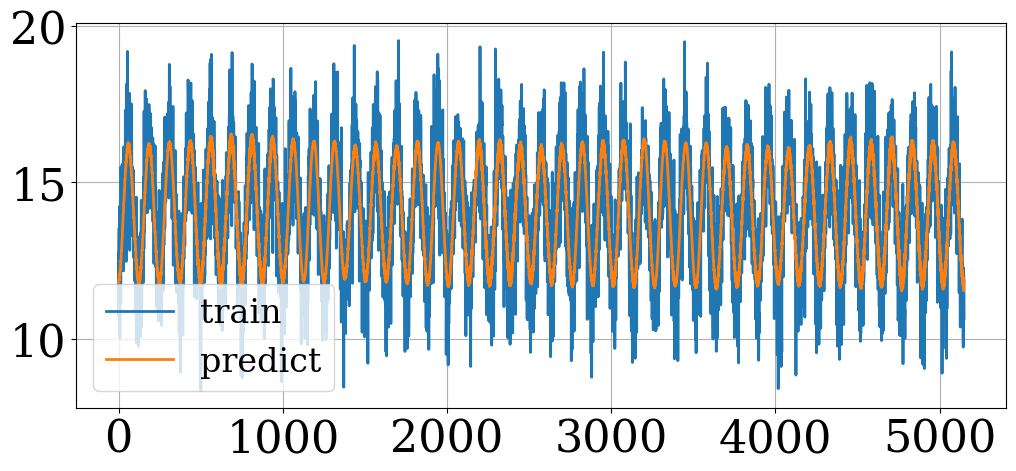

In [87]:
for i in range(actual_train_ts_corr.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(actual_train_ts_corr.T[i], label='train')
        ax.plot(pred_ts_corr.T[i], label='predict')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

In [88]:
# get MSE for every signal
signals_mse_tssa = np.mean((pred_ts_corr - actual_train_ts_corr) ** 2, axis=0)
# get MAPE for every signal
signals_mape_tssa = np.mean(np.abs((pred_ts_corr - actual_train_ts_corr) / actual_train_ts_corr), axis=0)

mean_mse = np.mean(signals_mse_tssa)
mean_mape = np.mean(signals_mape_tssa)

print(f'tssa_MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
print(f'tssa_MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa):e}')

tssa_MSE: [0.99648029 1.43492961]; Mean by signals = 1.215705e+00
tssa_MAPE: [0.08181866 0.07034542]; Mean by signals = 7.608204e-02


### Добавление ковариации к прогнозу tSSA

In [89]:
X_train_corr, X_test_corr, y_train_corr,  y_test_corr = tssa_cov_split(pred_ts_corr, actual_train_ts_corr, tsp_y)

In [90]:
scaler = StandardScaler()
scaler.fit(X_train_corr)
X_train_corr_transformed = scaler.transform(X_train_corr)
X_test_corr_transformed = scaler.transform(X_test_corr)

linear_reg_corr = LinearRegression()
linear_reg_corr.fit(X_train_corr, y_train_corr)

y_pred_train_corr = linear_reg_corr.predict(X_train_corr)
y_pred_test_corr = linear_reg_corr.predict(X_test_corr)

In [91]:
# get MSE for every signal
train_mse_cov_tssa = np.mean((y_pred_train_corr - y_train_corr) ** 2, axis=0)
# get MAPE for every signal
train_mape_cov_tssa = np.mean(np.abs((y_pred_train_corr - y_train_corr) / y_train_corr), axis=0)

print(f'train_MSE: {train_mse_cov_tssa}; Mean by signals = {np.mean(train_mse_cov_tssa):e}')
print(f'train_MAPE: {train_mape_cov_tssa}; Mean by signals = {np.mean(train_mape_cov_tssa):e}')

train_MSE: [0.99447379 1.43213839]; Mean by signals = 1.213306e+00
train_MAPE: [0.08188978 0.07038743]; Mean by signals = 7.613861e-02


In [92]:
# get MSE for every signal
test_mse_cov_tssa = np.mean((y_pred_test_corr - y_test_corr) ** 2, axis=0)
# get MAPE for every signal
test_mape_cov_tssa = np.mean(np.abs((y_pred_test_corr - y_test_corr) / y_test_corr), axis=0)

print(f'test_MSE: {test_mse_cov_tssa}; Mean by signals = {np.mean(test_mse_cov_tssa):e}')
print(f'test_MAPE: {test_mape_cov_tssa}; Mean by signals = {np.mean(test_mape_cov_tssa):e}')

test_MSE: [0.97638805 1.40591204]; Mean by signals = 1.191150e+00
test_MAPE: [0.08037458 0.06913937]; Mean by signals = 7.475698e-02


In [93]:
# get MSE for every signal
test_mse_tssa = np.mean((pred_ts_corr[y_train_corr.shape[0]:] - y_test_corr) ** 2, axis=0)
# get MAPE for every signal
test_mape_tssa = np.mean(np.abs((pred_ts_corr[y_train_corr.shape[0]:] - y_test_corr) / y_test_corr), axis=0)

print(f'tssa_test_MSE: {test_mse_tssa}; Mean by signals = {np.mean(test_mse_tssa):e}')
print(f'tssa_test_MAPE: {test_mape_tssa}; Mean by signals = {np.mean(test_mape_tssa):e}')

tssa_test_MSE: [0.97765848 1.40764802]; Mean by signals = 1.192653e+00
tssa_test_MAPE: [0.08019866 0.06901877]; Mean by signals = 7.460871e-02


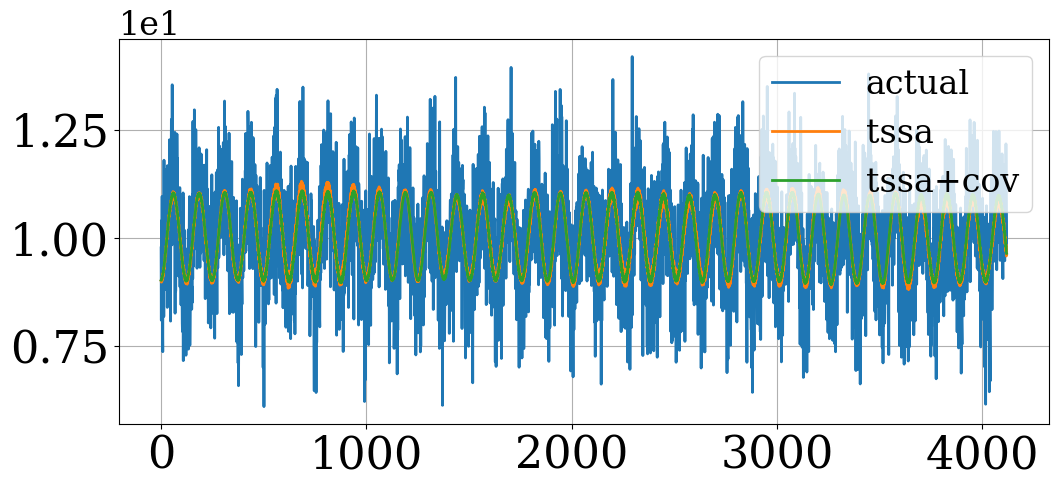

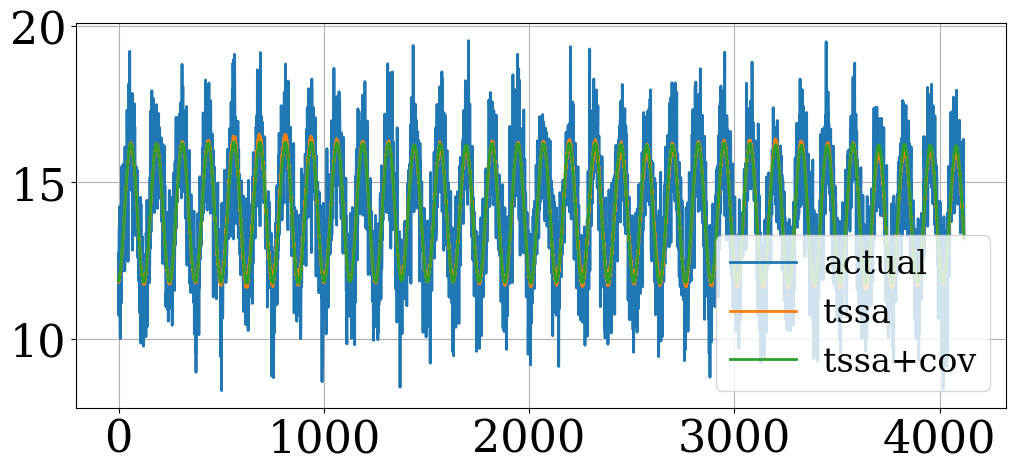

In [94]:
for i in range(actual_train_ts_corr.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(y_train_corr.T[i], label='actual')
        ax.plot(pred_ts_corr.T[i, :y_train_corr.shape[0]], label='tssa')
        ax.plot(y_pred_train_corr.T[i], label='tssa+cov')

        ax.grid(True)
        ax.legend()

        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=32)
        if i == 0:
            ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

In [95]:
weights = linear_reg_corr.coef_
bias = linear_reg_corr.intercept_

print("Веса (коэффициенты):", weights)
print("Свободный член (intercept):", bias)

Веса (коэффициенты): [[ -0.5424675    0.70117643 151.54551647 204.76436729 151.54551647]
 [ -1.84409905   1.83793537 181.79499411 245.63477567 181.79499411]]
Свободный член (intercept): [5.6190153  6.72311498]
